# Tutorial: Sensitivity Analysis (SA) to discover factors shaping consequential dynamics
This notebook demonstrates the application of sensitivity analysis to
discover factors that shape the behavior modes of a socio-ecological system
with dynamic human action.

The system of differential equations below represent a system of prey (defined in the equation below as x) and predator (defined as y) fish, with a human
actor harvesting the prey fish. You can read more about this system
at [Hadjimichael et al. (2020)](https://doi.org/10.1155/2020/4170453).

<img src="./figs/eqn2.png" width="300">


The table below defines the parameters in the system and also denotes the baseline and ranges associated with each uncertain parameter.  

<img src="./figs/table1.png" width="600">

The system is simple but very rich in the dynamic behaviors it exhibits. This complexity is accompanied by the presence of several equilibria that come in and out of existence with different parameter values. The equilibria
also change in their stability according to different parameter values,
giving rise to different behavior modes as shown by the diverse predator and prey abundace trajectories in the figure below. 

<img src="./figs/Figure_1.png" width="600">

In the unharvested system (without the human actor) the stability of
several of these equilibria can be derived analytically. The task becomes
significantly more difficult when the adaptive human actor is introduced,
deciding to harvest the system at different rates according to their objectives and preferences.

Sensitivity analysis methods can help us identify the factors that most
control these dynamics by exploring the space of parameter values and
seeing how system outputs change as a result.

Through previously conducted optimization, there already exists a set of potential
harvesting strategies that were identified in pursuit of five objectives:

- Maximize Harvesting Discounted Profits (Net Present Value)
- Minimize Prey Population Deficit
- Minimize Longest Duration of Consecutive Low Harvest
- Maximize Worst Harvest Instance
- Minimize Harvest Variance

The identified harvesting strategies also meet the necessary constraint of not causing inadvertent predator collapse. 

We will be examining the effects of parametric uncertainty on these identified
strategies, particularly focusing on two
strategies: one selected to maximize harvesting profits and one identified through
previous analysis to perform 'well enough' for all objectives across a wide range
of states of the world (referred to as the 'robust' harvesting policy). 

## Let's get started!

In this tutorial, we will be loading in data that has been produced in Hadjimichael et al. (2020). Before we start our analysis, we'll load the relevant Python libraries. __NOTE__: To step through the notebook, execute each gray (code) box by typing "Shift+Enter".

In [1]:
# Import necessary libraries
import numpy as np
from SALib.analyze import sobol

from msdbook.package_data import load_robustness_data, load_profit_maximization_data, load_saltelli_param_values, load_collapse_data
from msdbook.fishery_dynamics import *

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


##### **NOTE:**  If you are running this notebook locally, uncomment the following code to install the required package data:

In [2]:
# from msdbook.install_supplement import install_package_data
# install_package_data()

## Step 1:  Load identified solutions and explore performance
Here we load in the solution set obtained in Hadjimichael et al. (2020). The solution set contains the decision variables and objectives associated with a variety of harvesting policies. For this tutorial, we focus on comparing two policies: harvesting profits and one that performs robustly across all objectives. Below, we are reading in the decision variables and objectives from an external file that can be found within the msdbook package data.

In [3]:
robustness = load_robustness_data()
results = load_profit_maximization_data()

robust_solution = np.argmax(robustness[:,-1]) #pick robust solution
profit_solution = np.argmin(results[:,6]) #pick profitable solution
objective_performance = -results[:,6:] #Retain objective values 

# Get decision variables for each of the policies
highprofitpolicy = results[profit_solution,0:6]
mostrobustpolicy = results[robust_solution,0:6]


Next we plot the identified solutions with regards to their objective performance in a parallel axis plot

<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/msd_uncertainty_ebook/docs/html/A3_plotting_code.html#plot-objective-performance">plot_objective_performance</a>

</div>

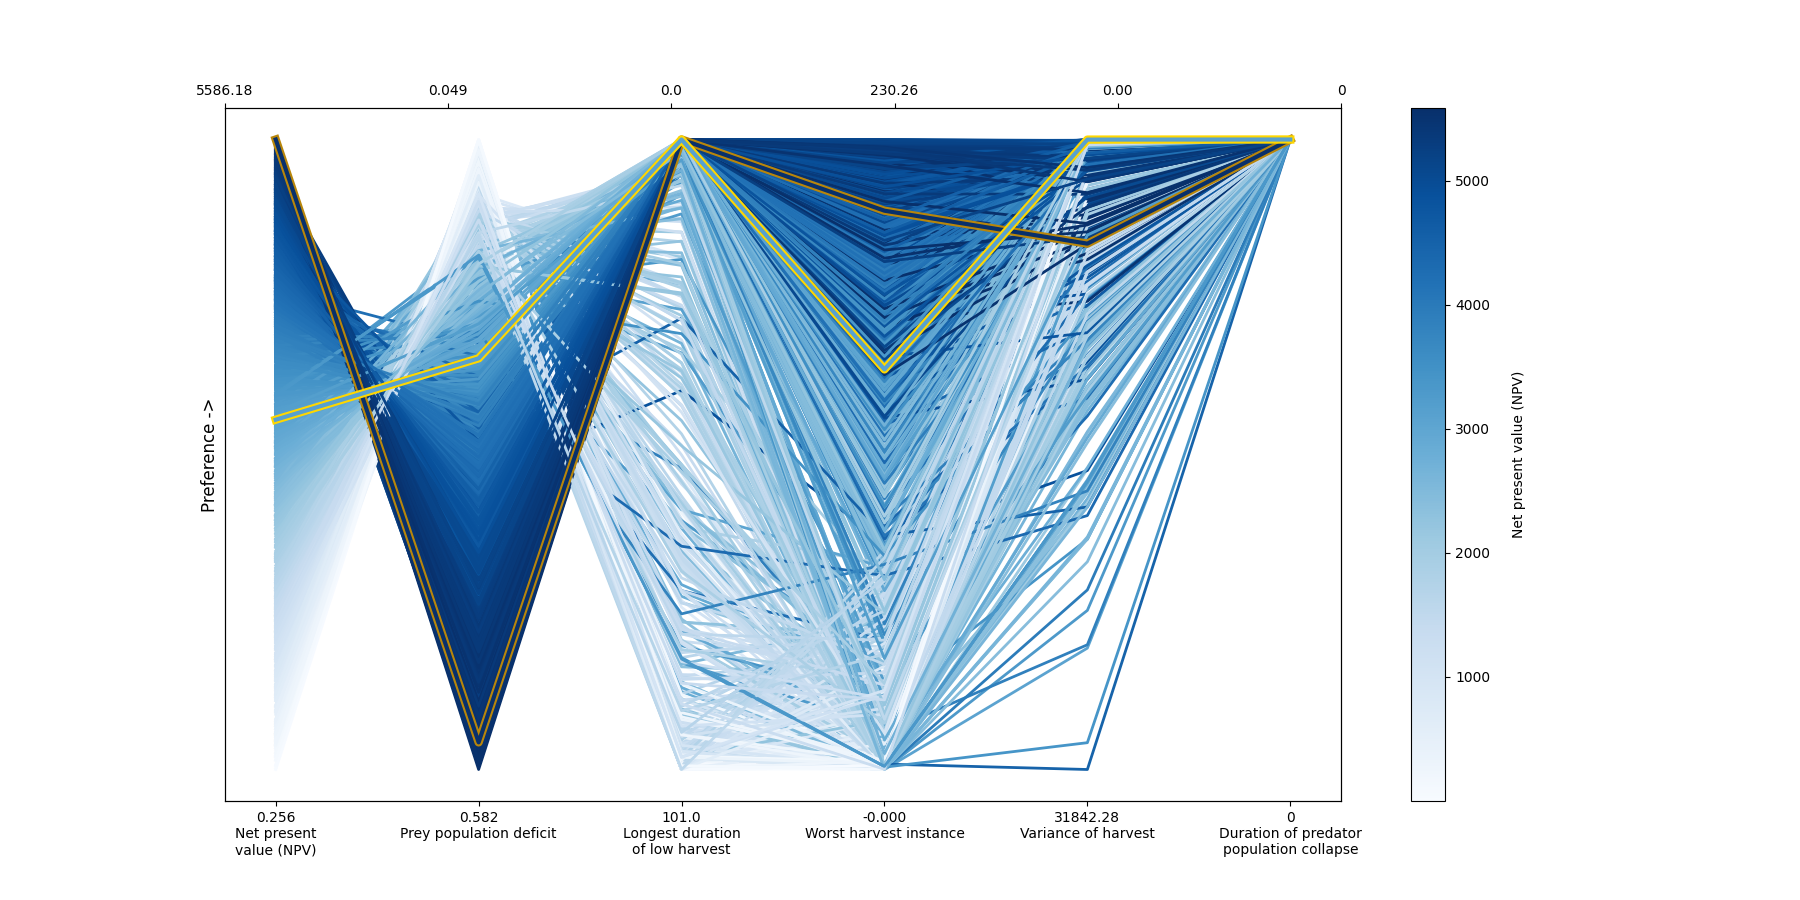

In [4]:
ax, ax1 = plot_objective_performance(objective_performance, profit_solution, robust_solution)


The solution set from the optimization in Hadjimichael et al. (2020) are presented in a parallel axis plot where each of the five objectives (and one constraint) are represented as an axis. Each solution on the Pareto front is represented as a line where the color of the line indicates the value of the NPV objective. The preference for objective values is in the upward direction. Therefore, the ideal solution would be a line straight across the top of the plot that satisfies every objective. However, no such line exists because there are tradeoffs when sets of objectives are prioritized over the others. When lines cross in between axes, this indicates a tradeoff between objectives (as seen in the first two axes).The solution that is most robust in the NPV objective has the highest value on the first axis and is outlined in dark gold. The solution that is most robust across all objectives is outlined in a brighter yellow. A parallel axis is an effective visual to characterize high-dimensional tradeoffs in the system and visualize differences in performance across policies. 

## Step 2: Use SALib to generate a sample for a Sobol sensitivity analysis
In Step 1, we showed how the optimized harvesting policies performed in the objective space, which utilized the baseline parameters outlined in the table above. Now, we are interested in understanding how sensitive our two policies are to alternative states of the world that may be characterized by different parameter values. To do so, we first need to define the problem dictionary that allows us to generate these alternative states of the world.

In [5]:
# Set up SALib problem
problem = {
  'num_vars': 9,
  'names': ['a', 'b', 'c', 'd', 'h', 'K', 'm', 'sigmaX', 'sigmaY'],
  'bounds': [[0.002, 2], [0.005, 1], [0.2, 1], [0.05, 0.2], [0.001, 1],
             [100, 5000], [0.1, 1.5], [0.001, 0.01], [0.001, 0.01]]
}


Then we use the following command to generate a Saltelli sample from these defined ranges:

```python
param_values = saltelli.sample(problem, 1024, calc_second_order=False)
```
Generally, it is a good idea to save the result of the sample since it is often reused and regenerating it produces a different sample set.  For this reason, we will load one from file that was previously generated.


In [6]:
# load previously generated Saltelli sample from our msdbook package data
param_values = load_saltelli_param_values()


## Step 3: Evaluate the system over all generated states of the world
Now we re-evaluate how well the policies do in the new states of the world. In order to characterize failure of a policy, we identify the states where the predator population collapses, as an inadvertent consequence of applying the harvesting strategy under a state of the world different from the one originally assumed. Due to how long this step takes to execute within the tutorial, we will read in the solutions from an external file. However, the block of code below shows how evaluation can be implemented. 

```python
# create array to store collapse values under both policies
collapse_days = np.zeros([len(param_values), 2])

# evaluate performance under every state
for i in range(len(param_values)):
    
    additional_inputs = np.append(['Previous_Prey'],
                                  [param_values[i,0],
                                   param_values[i,1],
                                   param_values[i,2],
                                   param_values[i,3],
                                   param_values[i,4],
                                   param_values[i,5],
                                   param_values[i,6],
                                   param_values[i,7],
                                   param_values[i,8]])
    
    collapse_days[i,0]=fish_game(highprofitpolicy, additional_inputs)[1][0]
    collapse_days[i,1]=fish_game(mostrobustpolicy, additional_inputs)[1][0]
```


In [7]:
# load the simulation data from our msdbook package data
collapse_days = load_collapse_data()


## Step 4: Calculate sensitivity indices
Now we use a Sobol sensitivity analysis to calculate first-order, second-order, and total-order sensitivity indices for each parameter and for each of the two policies. These indicies help determine which factors explain the most variability in the number of days of predator population collapse. 

In [8]:
#Perform the Sobol SA for the profit-maximizing solution
Si_profit = sobol.analyze(problem, collapse_days[:, 0], 
                          calc_second_order=False, 
                          conf_level=0.95, 
                          print_to_console=True)


              ST   ST_conf
a       0.278724  0.049432
b       0.188124  0.031697
c       0.015588  0.010329
d       0.077655  0.016108
h       0.025096  0.011867
K       0.033239  0.014204
m       0.845465  0.077932
sigmaX  0.000708  0.000848
sigmaY  0.000849  0.000456
              S1   S1_conf
a       0.126405  0.046331
b       0.060739  0.039235
c       0.003333  0.009032
d       0.011388  0.023901
h       0.010233  0.011742
K       0.016699  0.012745
m       0.609991  0.071739
sigmaX  0.000531  0.001504
sigmaY  0.000337  0.002072


/Users/rexe871/Library/CloudStorage/OneDrive-PNNL/Documents/IM3/repos/msd_uncertainty_ebook/.venv3.9.12/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [9]:
#Perform the Sobol SA for the robust solution
Si_robustness = sobol.analyze(problem, 
                              collapse_days[:, 1], 
                              calc_second_order=False, 
                              conf_level=0.95, 
                              print_to_console=True)


              ST   ST_conf
a       0.226402  0.040589
b       0.066819  0.015336
c       0.004395  0.004825
d       0.024509  0.006469
h       0.009765  0.005758
K       0.020625  0.010477
m       0.897971  0.069638
sigmaX  0.000136  0.000143
sigmaY  0.000739  0.000959
              S1   S1_conf
a       0.087936  0.044412
b       0.000554  0.019646
c      -0.002970  0.004502
d       0.001206  0.014423
h       0.004554  0.008053
K       0.003843  0.012982
m       0.751301  0.062702
sigmaX -0.000325  0.001302
sigmaY -0.001887  0.002840


/Users/rexe871/Library/CloudStorage/OneDrive-PNNL/Documents/IM3/repos/msd_uncertainty_ebook/.venv3.9.12/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Looking at the total-order indices, (ST) factors $m$, $a$, $b$, $d$
and $K$ explain a non-negligible amount of variance therefore have an effect on the stability of this system. Looking at the first-order
indices (S1), we also see that besides factors $m$ and $a$, all other factors are
important in this system through their interactions, which make up the
difference between their S1 and ST indices. This shows the danger of limiting sensitivity analyses to first order effects, as factor importance might be significantly misjudged.

These findings are supported by the analytical condition of equilibrium
stability in this system:

<img src="./figs/eqn4.png">

In an unharvested system, this condition is both necessary and sufficient for the equilibrium of the two species coexisting to be stable. 

When adaptive human action is introduced however, this condition is still necessary, but no longer sufficient, as harvesting reduces the numbers of prey
fish and as a result reduces the resources for the predator fish.
Since this harvesting value is not constant, but can dynamically
adapt according to the harvester's objectives, it cannot be
introduced into this simple equation.

## Step 5: Explore relationship between uncertain factors and performance
In the following steps, we will use the results of our sensitivity analysis to investigate the relationships between 
parametric uncertainty, equilibrium stability and the performance of the two policies.

We can use the top three factors identified ($m$, $a$, and $b$) to visualize the performance of our policies in this three-dimensional parametric space. 

We first define the stability condition, as a function of $b$ and $m$, and calculate the corresponding values of $a$. 

In [10]:
def inequality(b, m, h, K):
    return ((b**m)/(h*K)**(1-m))

# boundary interval that separates successful and failed states of the world
b = np.linspace(start=0.005, stop=1, num=1000)
m = np.linspace(start=0.1, stop=1.5, num=1000)
h = np.linspace(start=0.001, stop=1, num=1000)
K = np.linspace(start=100, stop=2000, num=1000)
b, m = np.meshgrid(b, m)
a = inequality(b, m, h, K)
a = a.clip(0,2)


<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/msd_uncertainty_ebook/docs/html/A3_plotting_code.html#plot-factor-performance">plot_factor_performance</a>

</div>

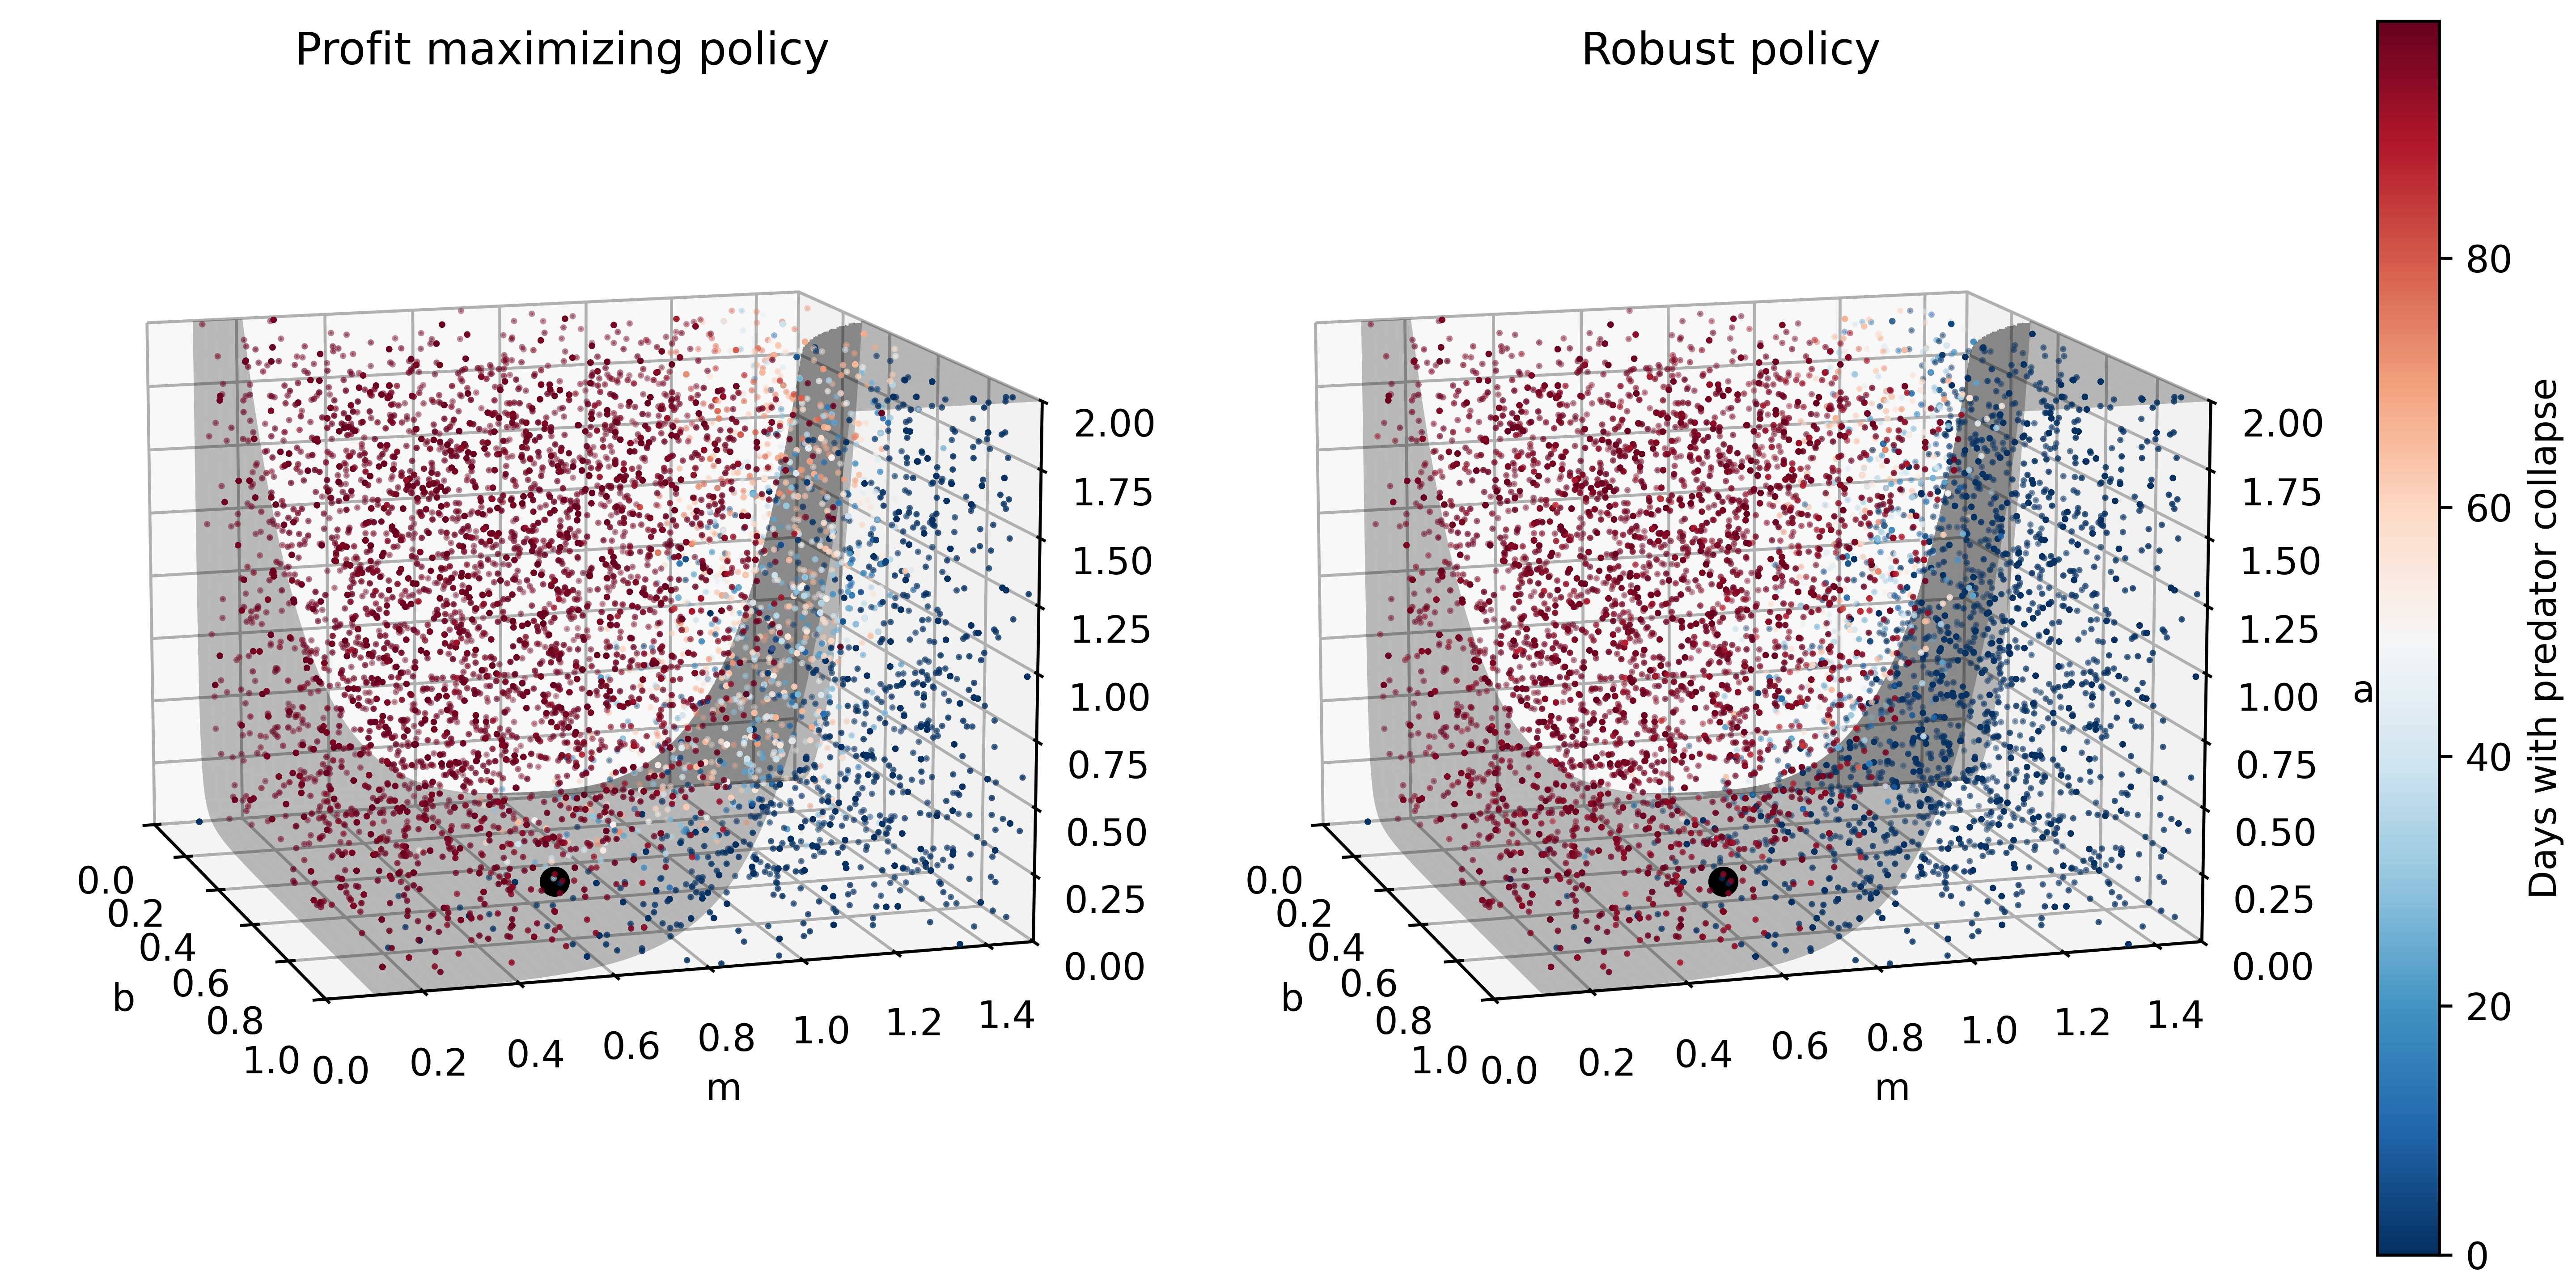

In [11]:
# generate plot
ax1, ax2 = plot_factor_performance(param_values, collapse_days, b, m, a)


These figures show the combinations of factors that lead to success or failure in different states of the world for the profit-maximizing and robust policies. Each point is a state of the world, characterized by specific values of the parameters, and ideally, we would like the color of the point to be blue, to represent that there are a low number of days with a predator collapse in that world. The gray curve denotes the highly non-linear nature of the boundary, defined by the stability condition, that separates successful and failed states of the world. The figures demonstrate the following key points:  

First, as asserted above, the policies interact with the system in different and complex ways. In the presence of human action, the stability condition is not sufficient in determining whether the policy will succeed, even though it clearly shapes the system in a fundamental manner. 

Secondly, the robust policy manages to avoid collapse in many more of the sampled states of the world, indicated by the number of blue points. The robust policy avoids collapse in 31% of worlds versus 14% in the profit-maximizing policy. This presents a clear tradeoff between profit-maximizing performance and robustness against uncertainty.


## Tips to Apply Sobol SA and Scenario Discovery to your Problem 

In this tutorial, we demonstrated a Sobol SA to identify the most important factors driving the behavior of a system (i.e. the number of the collapse days). In order to apply this methodology to your problem, you will need to have a set of optimized policies for your system that you are interested in analyzing. The general workflow is as follows:

1. Choose sampling bounds for your parameters and set up the problem dictionary as in Step 2 above.
2. Generate samples, or alternative states of the world using the `saltelli.sample` function. 
3. Evaluate your policies on the alternative states of the world. For your application, you will also need to develop a rule for determining success or failure of your policy in a new SOW. In this tutorial, success was denoted by a small number of collapse days. Ultimately, the rule will be specific to your application and can include various satisficing criteria.  
4. Calculate the Sobol indices and discover the most important parameters driving success and failure. 
5. Finally, use a similar plotting procedure as in step 5 to identify the combination of parameter values that lead to success and failure in the system. 

